In [143]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [289]:
headers=['Interval','Timestamp','Flume Depth (mm)','AV Flow (L/s)', 'Flume Flow (L/s)', 'Precipitation (mm)']
df = pd.read_csv ('central1_sani.csv', names=headers)
df=df[1:]
# df=df.astype(float)
df.head()

,Interval,Timestamp,Flume Depth (mm),AV Flow (L/s),Flume Flow (L/s),Precipitation (mm)
1,15 Min,2021-04-01 0:15,14.16,0.4,0.22,0
2,15 Min,2021-04-01 0:30,14.95,0.24,0.29,0
3,15 Min,2021-04-01 0:45,14.88,0.15,0.21,0
4,15 Min,2021-04-01 1:00,13.1,0.17,0.21,0
5,15 Min,2021-04-01 1:15,13.96,0.23,0.21,0


In [145]:
date_time = pd.to_datetime(df.pop('Timestamp'), format='%Y-%m-%d %H:%M:')

In [290]:
df=df[['Flume Depth (mm)','AV Flow (L/s)', 'Flume Flow (L/s)','Precipitation (mm)']].astype(float)

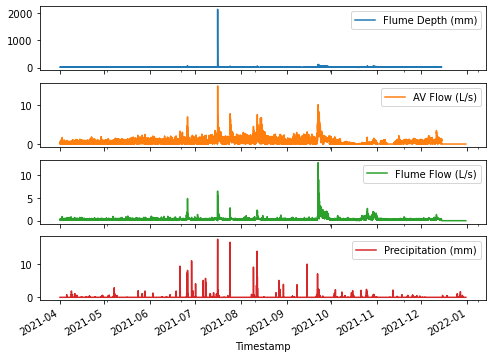

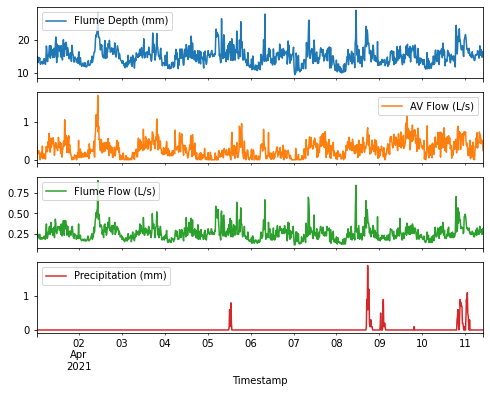

In [147]:
plot_cols = ['Flume Depth (mm)','AV Flow (L/s)', 'Flume Flow (L/s)','Precipitation (mm)']#'T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:1000]
plot_features.index = date_time[:1000]
_ = plot_features.plot(subplots=True)

In [148]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Flume Depth (mm),24730.0,16.324478,29.263451,5.29,12.50,14.49,16.80,2130.02
AV Flow (L/s),26304.0,0.628436,0.789814,0.00,0.12,0.43,0.86,15.05
Flume Flow (L/s),26304.0,0.296706,0.378716,0.00,0.17,0.23,0.30,12.78
Precipitation (mm),26399.0,0.031793,0.324175,0.00,0.00,0.00,0.00,17.50


In [149]:
date_time.head()

1   2021-04-01 00:15:00
2   2021-04-01 00:30:00
3   2021-04-01 00:45:00
4   2021-04-01 01:00:00
5   2021-04-01 01:15:00
Name: Timestamp, dtype: datetime64[ns]

In [291]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

TypeError: descriptor 'timestamp' for 'pandas._libs.tslibs.timestamps._Timestamp' objects doesn't apply to a 'NaTType' object

In [151]:
day = 24*60*60
year = (365.2425)*day
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

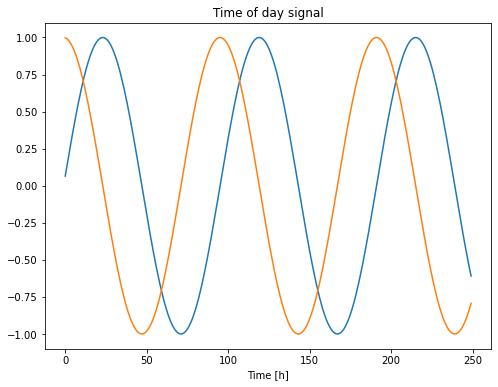

In [152]:
plt.plot(np.array(df['Day sin'])[:250])
plt.plot(np.array(df['Day cos'])[:250])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

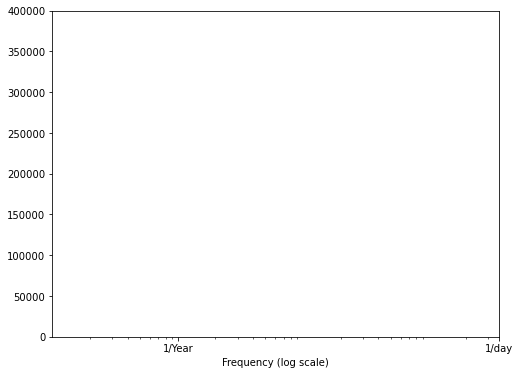

In [153]:
fft = tf.signal.rfft(df['Flume Flow (L/s)'])#'AV Flow (L/s)', 'Flume Flow (L/s)'
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Flume Flow (L/s)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [154]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [155]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

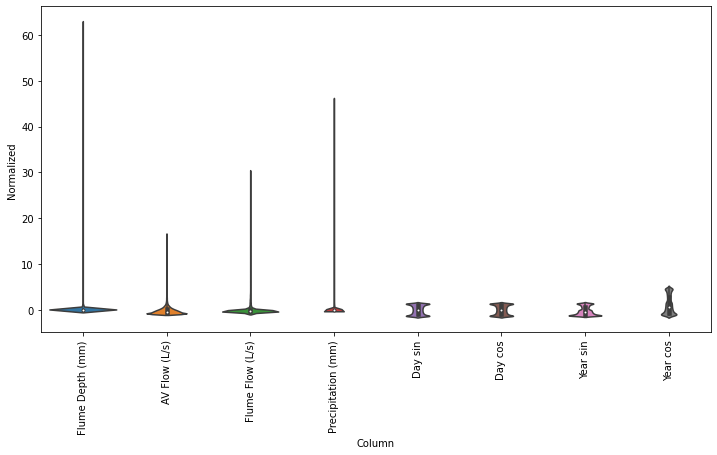

In [156]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [157]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [158]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=1,
                     label_columns=['AV Flow (L/s)'])
w1

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['AV Flow (L/s)']

In [159]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [160]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 25, 8)
Inputs shape: (3, 24, 8)
Labels shape: (3, 1, 1)


In [161]:
w1.example = example_inputs, example_labels

In [162]:
def plot(self, model=None, plot_col='AV Flow (L/s)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

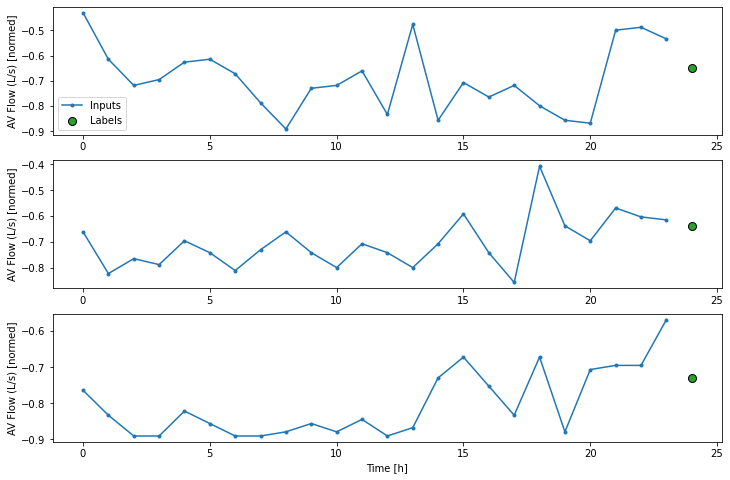

In [163]:
w1.plot()

In [164]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [165]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [166]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 24, 8), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [167]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['AV Flow (L/s)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['AV Flow (L/s)']

In [168]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [170]:
baseline = Baseline(label_index=column_indices['AV Flow (L/s)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.Accuracy()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

165/165 [==============================] - 2s 10ms/step - loss: 0.0415 - mean_absolute_error: 0.1268 - accuracy: 0.2112


In [214]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['AV Flow (L/s)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['AV Flow (L/s)']

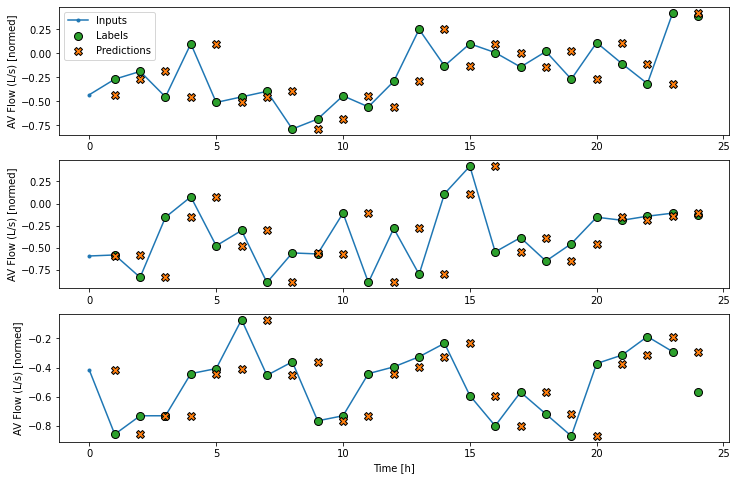

In [215]:
wide_window.plot(baseline)

In [173]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [216]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.keras.metrics.Accuracy()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [175]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
578/578 [==============================] - 8s 13ms/step - loss: 1.6699 - mean_absolute_error: 0.7212 - accuracy: 0.0000e+00 - val_loss: 0.2698 - val_mean_absolute_error: 0.4127 - val_accuracy: 0.0000e+00
Epoch 2/100
578/578 [==============================] - 7s 13ms/step - loss: 0.9377 - mean_absolute_error: 0.4904 - accuracy: 0.0000e+00 - val_loss: 0.1513 - val_mean_absolute_error: 0.3242 - val_accuracy: 0.0000e+00
Epoch 3/100
578/578 [==============================] - 8s 14ms/step - loss: 0.6478 - mean_absolute_error: 0.4046 - accuracy: 0.0000e+00 - val_loss: 0.0852 - val_mean_absolute_error: 0.2353 - val_accuracy: 0.0000e+00
Epoch 4/100
578/578 [==============================] - 8s 13ms/step - loss: 0.5224 - mean_absolute_error: 0.3696 - accuracy: 0.0000e+00 - val_loss: 0.0603 - val_mean_absolute_error: 0.1846 - val_accuracy: 0.0000e+00
Epoch 5/100
578/578 [==============================] - 8s 14ms/step - loss: 0.4594 - mean_absolute_error: 0.3565 - accuracy: 0.0000e+00 

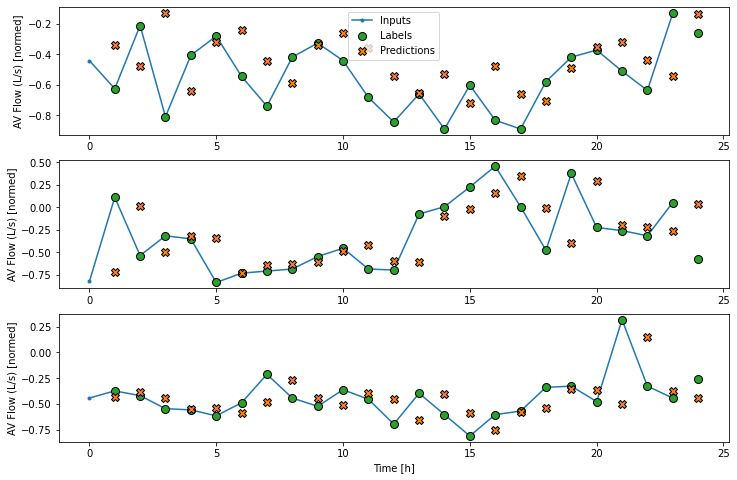

In [176]:
wide_window.plot(linear)

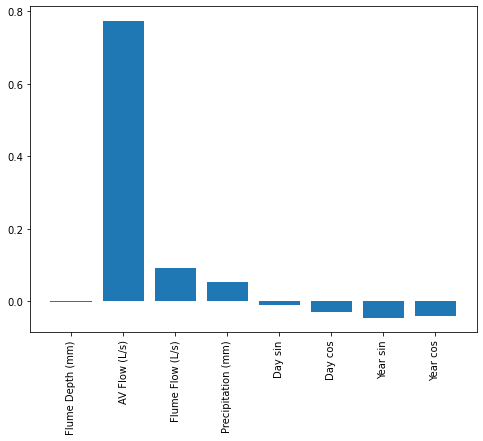

In [177]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [178]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='softmax'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
578/578 [==============================] - 8s 13ms/step - loss: 0.6270 - mean_absolute_error: 0.4353 - accuracy: 0.0000e+00 - val_loss: 0.1022 - val_mean_absolute_error: 0.2739 - val_accuracy: 0.0000e+00
Epoch 2/100
578/578 [==============================] - 7s 12ms/step - loss: 0.4826 - mean_absolute_error: 0.3872 - accuracy: 0.0000e+00 - val_loss: 0.0955 - val_mean_absolute_error: 0.2565 - val_accuracy: 0.0000e+00
Epoch 3/100
578/578 [==============================] - 8s 13ms/step - loss: 0.4158 - mean_absolute_error: 0.3689 - accuracy: 0.0000e+00 - val_loss: 0.0880 - val_mean_absolute_error: 0.2454 - val_accuracy: 0.0000e+00
Epoch 4/100
578/578 [==============================] - 9s 16ms/step - loss: 0.3716 - mean_absolute_error: 0.3573 - accuracy: 0.0000e+00 - val_loss: 0.0905 - val_mean_absolute_error: 0.2412 - val_accuracy: 0.0000e+00
Epoch 5/100
578/578 [==============================] - 8s 13ms/step - loss: 0.3408 - mean_absolute_error: 0.3488 - accuracy: 0.0000e+00 

In [179]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['AV Flow (L/s)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['AV Flow (L/s)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

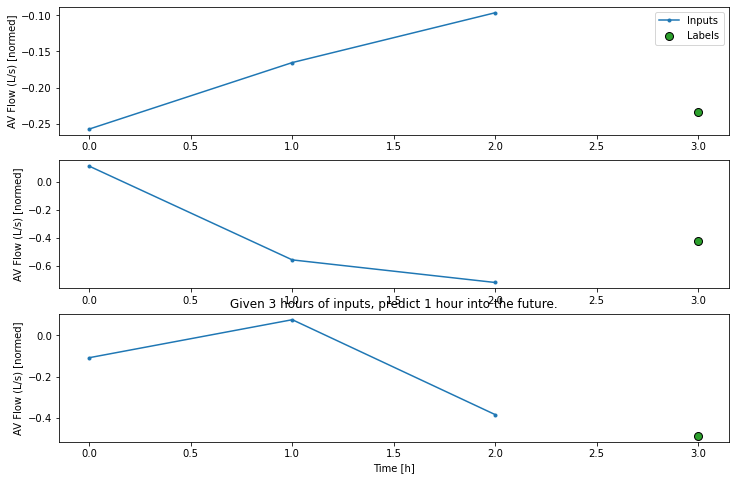

In [180]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [191]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])



In [192]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 8)
Output shape: (32, 1, 1)


In [193]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

165/165 [==============================] - 2s 10ms/step - loss: 0.0413 - mean_absolute_error: 0.1415 - accuracy: 0.0000e+00


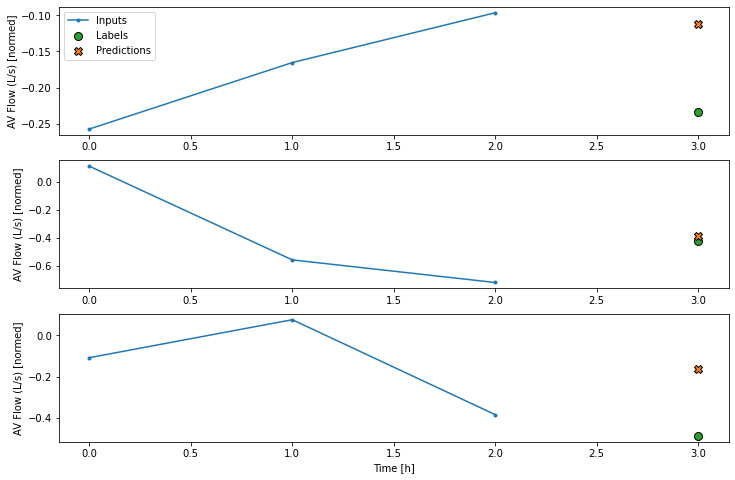

In [194]:
conv_window.plot(multi_step_dense)

In [195]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 8)

ValueError:Input 0 of layer dense_41 is incompatible with the layer: expected axis -1 of input shape to have value 24 but received input with shape (32, 192)


In [198]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [199]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 8)
Output shape: (32, 1, 1)


In [200]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

165/165 [==============================] - 2s 10ms/step - loss: 0.1018 - mean_absolute_error: 0.2405 - accuracy: 0.0000e+00


In [201]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 8)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [202]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['AV Flow (L/s)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['AV Flow (L/s)']

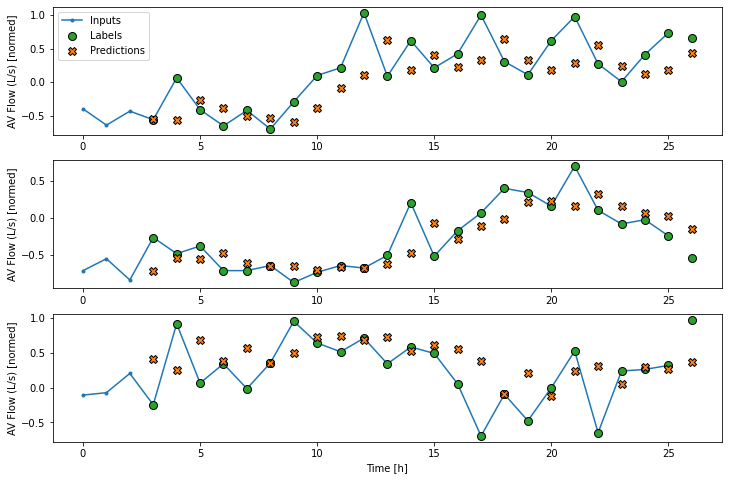

In [203]:
wide_conv_window.plot(conv_model)

In [219]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [220]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

165/165 [==============================] - 2s 11ms/step - loss: 0.0819 - mean_absolute_error: 0.1955 - accuracy: 0.0000e+00


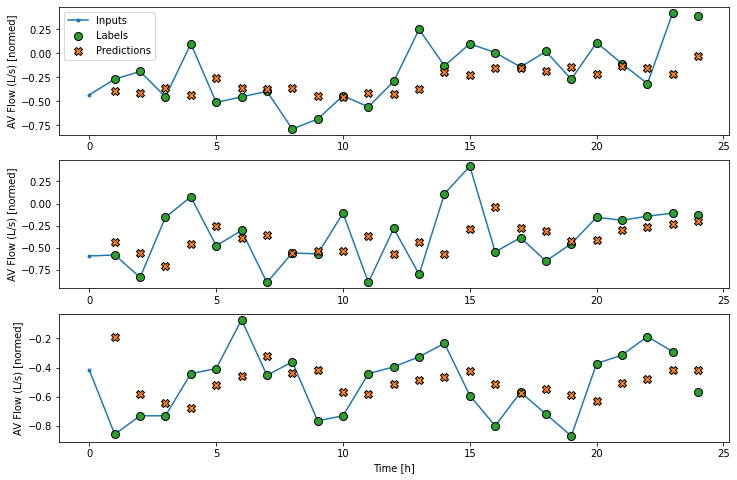

In [221]:
wide_window.plot(lstm_model)

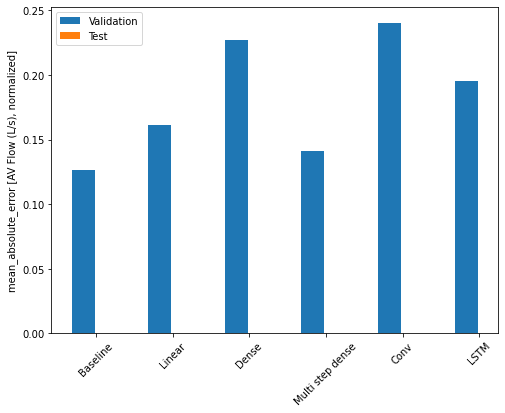

In [222]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [AV Flow (L/s), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [223]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 8)
Labels shape (batch, time, features): (32, 24, 8)


In [224]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [225]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

165/165 [==============================] - 2s 9ms/step - loss: 0.0224 - mean_absolute_error: 0.0614


In [226]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [227]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

165/165 [==============================] - 2s 10ms/step - loss: 0.0523 - mean_absolute_error: 0.1582 - accuracy: 0.0000e+00


In [229]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(12, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

165/165 [==============================] - 2s 10ms/step - loss: 0.0810 - mean_absolute_error: 0.1921 - accuracy: 0.0000e+00

CPU times: user 3min 41s, sys: 5min 6s, total: 8min 48s
Wall time: 2min 58s


In [230]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
        return inputs + delta

In [231]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(12, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

165/165 [==============================] - 2s 12ms/step - loss: 0.0236 - mean_absolute_error: 0.0714 - accuracy: 9.7111e-05

CPU times: user 1min 21s, sys: 1min 52s, total: 3min 14s
Wall time: 59.4 s


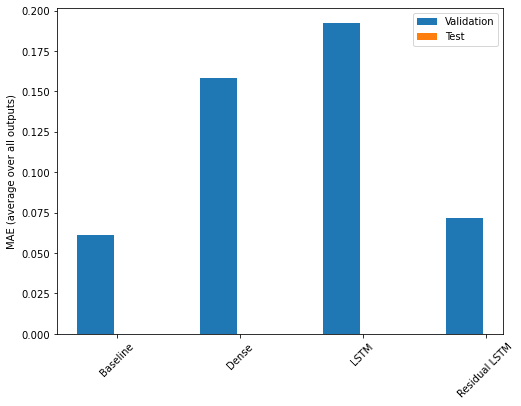

In [232]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [233]:
for name, value in performance.items():
    print(f"{name:15s}: {value[1]:0.4f}")

Baseline       : nan
Dense          : nan
LSTM           : nan
Residual LSTM  : nan


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

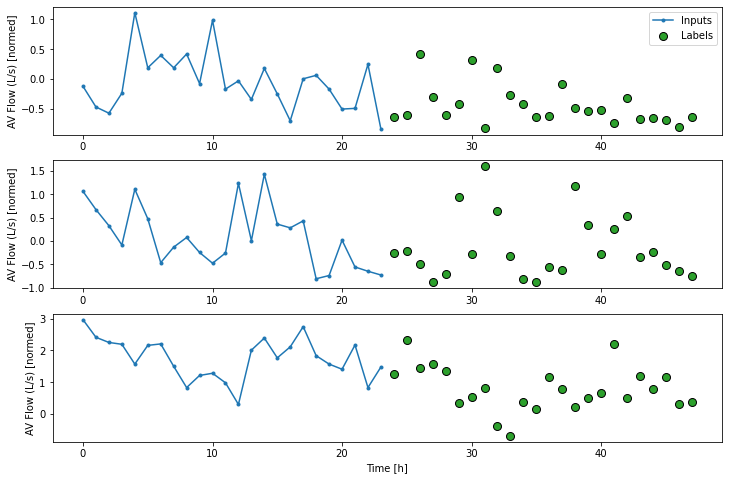

In [234]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

164/164 [==============================] - 2s 9ms/step - loss: 0.2478 - mean_absolute_error: 0.2526


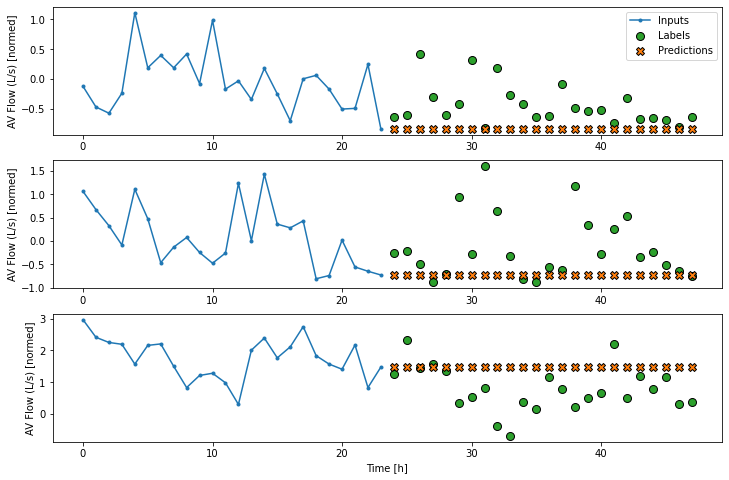

In [235]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

164/164 [==============================] - 2s 9ms/step - loss: 0.5743 - mean_absolute_error: 0.4143


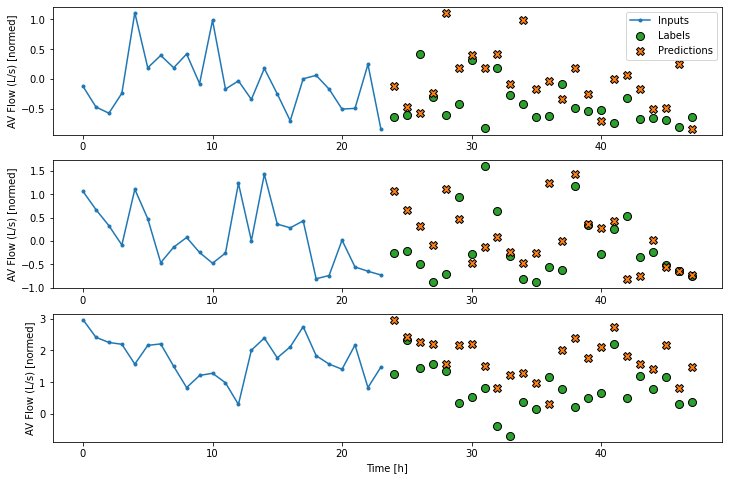

In [236]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

164/164 [==============================] - 2s 10ms/step - loss: 0.0588 - mean_absolute_error: 0.1038 - accuracy: 0.0323


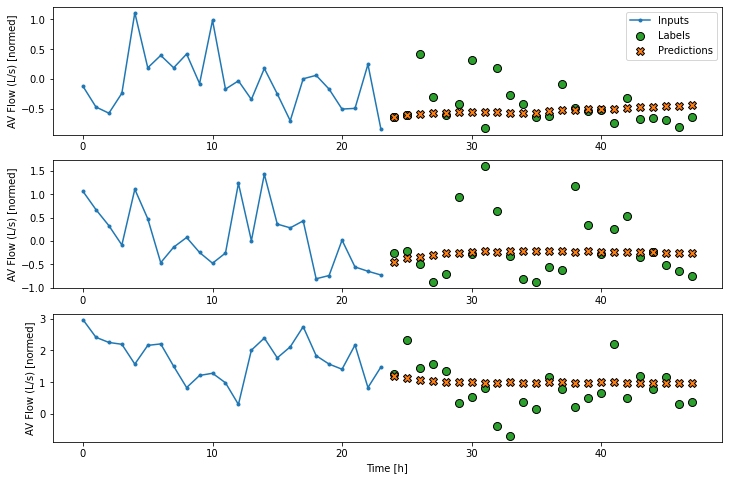

In [237]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

164/164 [==============================] - 2s 9ms/step - loss: 0.0842 - mean_absolute_error: 0.1508 - accuracy: 9.9529e-07


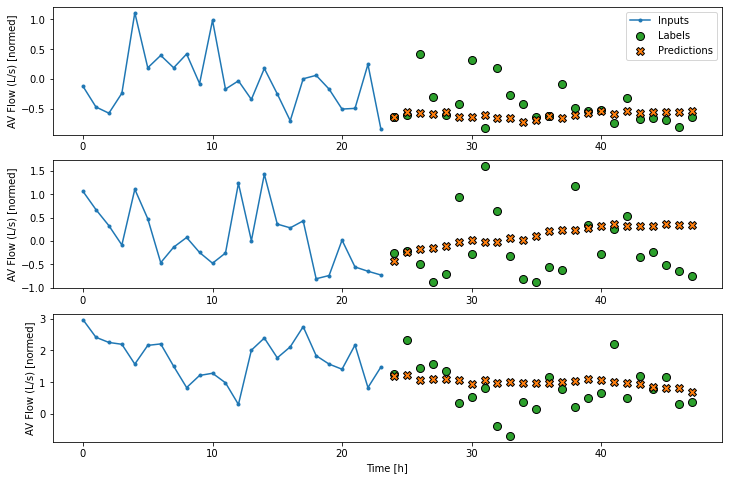

In [238]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

164/164 [==============================] - 2s 10ms/step - loss: 0.1212 - mean_absolute_error: 0.1942


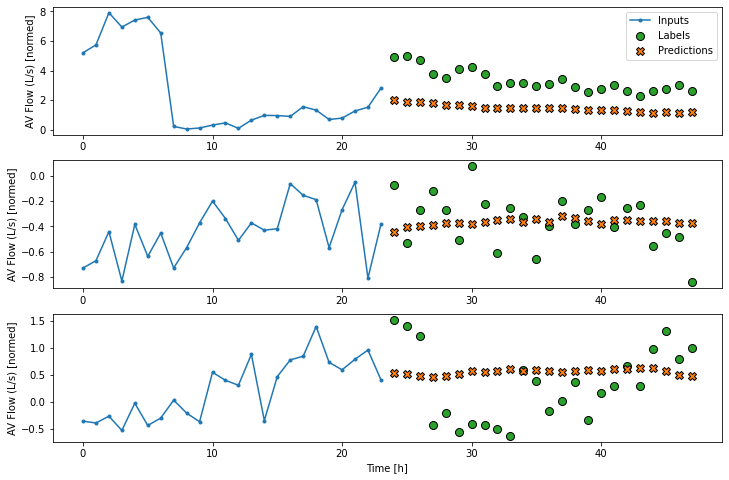

In [127]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

164/164 [==============================] - 2s 11ms/step - loss: 0.1205 - mean_absolute_error: 0.2066


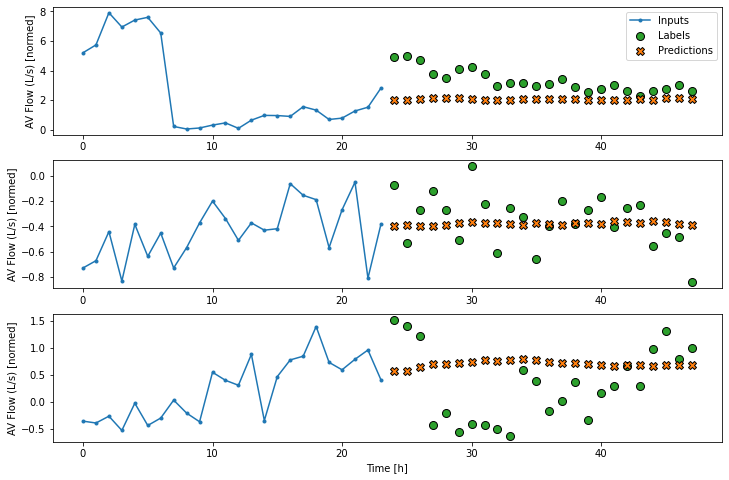

In [128]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [129]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [130]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [131]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [132]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 4])

In [133]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
  # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

  # Insert the first prediction.
    predictions.append(prediction)

  # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
    # Use the last prediction as input.
        x = prediction
    # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
        prediction = self.dense(x)
    # Add the prediction to the output.
        predictions.append(prediction)

  # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call


In [134]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 4)


164/164 [==============================] - 2s 12ms/step - loss: 0.1207 - mean_absolute_error: 0.2038


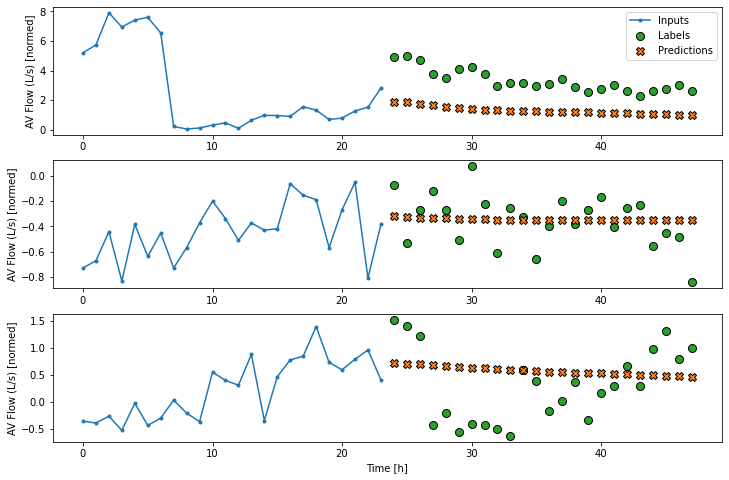

In [135]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

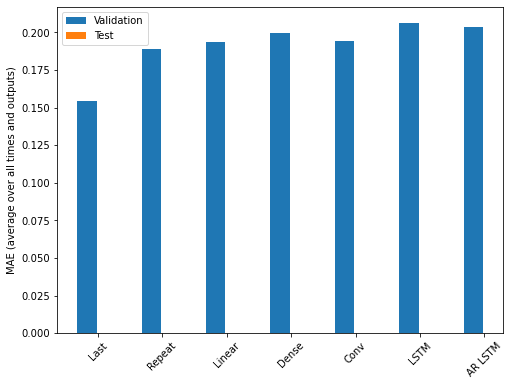

In [136]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [239]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [267]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

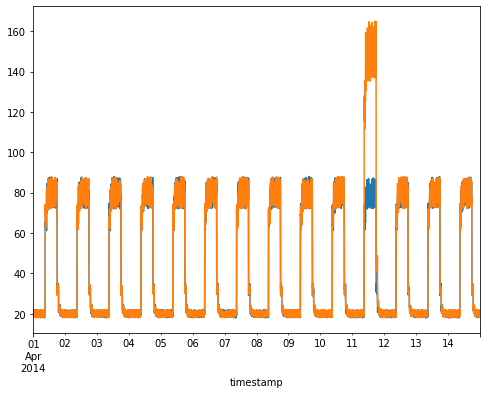

In [272]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
df_daily_jumpsup.plot(legend=False, ax=ax)

plt.show()

In [245]:
timestamp_s


1        1.617236e+09
2        1.617237e+09
3        1.617238e+09
4        1.617239e+09
5        1.617240e+09
             ...     
26300    1.640905e+09
26301    1.640906e+09
26302    1.640907e+09
26303    1.640908e+09
26304    1.640909e+09
Name: Timestamp, Length: 26304, dtype: float64

In [282]:
headers=['Interval','Timestamp','Flume Depth (mm)','AV Flow (L/s)', 'Flume Flow (L/s)', 'Precipitation (mm)']
df_2 = pd.read_csv ('central1_sani_anomaly.csv', names=headers)

df_2=df[1:]
# df_2=df_2.astype(float)


,Interval,Timestamp,Flume Depth (mm),AV Flow (L/s),Flume Flow (L/s),Precipitation (mm)
2,15 Min,2021-04-01 0:30,14.95,0.24,0.29,0
3,15 Min,2021-04-01 0:45,14.88,0.15,0.21,0
4,15 Min,2021-04-01 1:00,13.1,0.17,0.21,0
5,15 Min,2021-04-01 1:15,13.96,0.23,0.21,0
6,15 Min,2021-04-01 1:30,14.62,0.24,0.24,0


In [287]:
# df_2=df_2.drop(columns=['Interval','Timestamp'])
df_2=df_2.astype(float)
df_2.head()

,Flume Depth (mm),AV Flow (L/s),Flume Flow (L/s),Precipitation (mm)
2,14.95,0.24,0.29,0.0
3,14.88,0.15,0.21,0.0
4,13.10,0.17,0.21,0.0
5,13.96,0.23,0.21,0.0
6,14.62,0.24,0.24,0.0


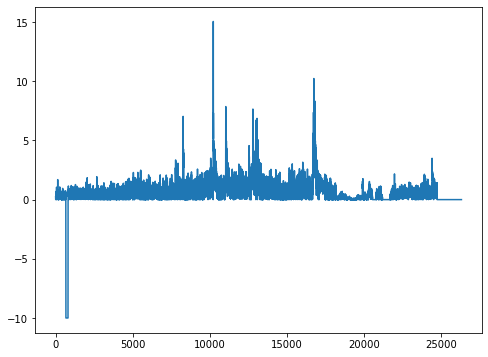

In [288]:
fig, ax = plt.subplots()
df_2['AV Flow (L/s)'].plot(legend=False, ax=ax)
plt.show()

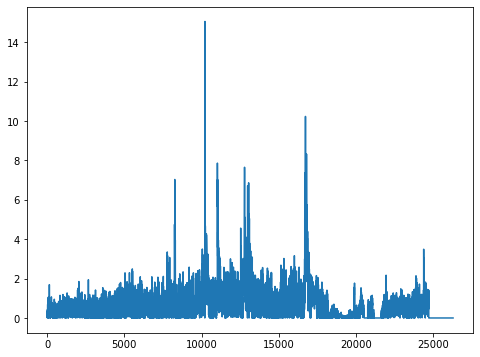

In [292]:
fig, ax = plt.subplots()
df['AV Flow (L/s)'].plot(legend=False, ax=ax)
plt.show()

In [293]:
df.head()

,Flume Depth (mm),AV Flow (L/s),Flume Flow (L/s),Precipitation (mm)
1,14.16,0.40,0.22,0.0
2,14.95,0.24,0.29,0.0
3,14.88,0.15,0.21,0.0
4,13.10,0.17,0.21,0.0
5,13.96,0.23,0.21,0.0


In [247]:
training_mean = df['AV Flow (L/s)'].mean()
training_std = df['AV Flow (L/s)'].std()
df_training_value = (df['AV Flow (L/s)'] - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 26399


In [256]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (26112, 288)


In [261]:
x_train = x_train[..., None]
x_train.shape

(26112, 288, 1)

In [260]:
x_train.shape[2]

IndexError: tuple index out of range

In [262]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_6 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_5 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_7 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_8 (Conv1DTr (None, 288, 1)          

In [263]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
735/735 [==============================] - 11s 14ms/step - loss: 0.0998 - val_loss: nan
Epoch 2/50
735/735 [==============================] - 10s 13ms/step - loss: 0.0356 - val_loss: nan
Epoch 3/50
735/735 [==============================] - 10s 13ms/step - loss: 0.0266 - val_loss: nan
Epoch 4/50
735/735 [==============================] - 10s 13ms/step - loss: 0.0216 - val_loss: nan
Epoch 5/50
735/735 [==============================] - 10s 14ms/step - loss: 0.0191 - val_loss: nan


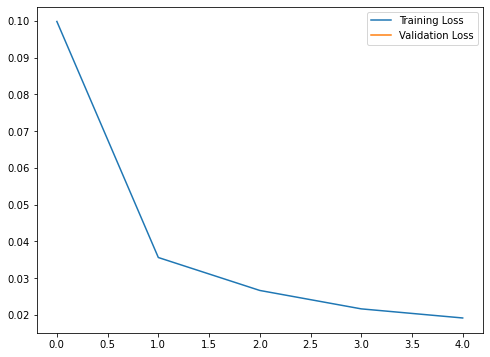

In [264]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

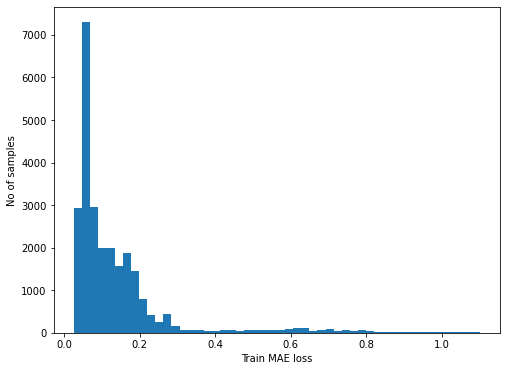

Reconstruction error threshold:  nan


In [265]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

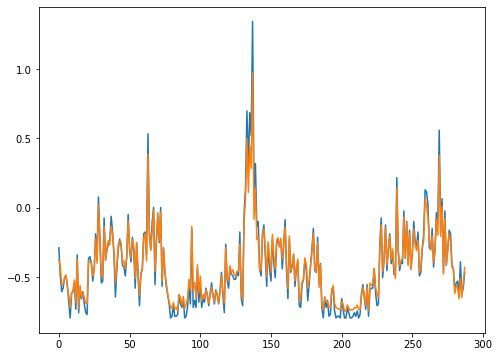

In [266]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [297]:
x_test.shape

(26111, 288)

In [305]:

x_test.shape

(26111, 288)

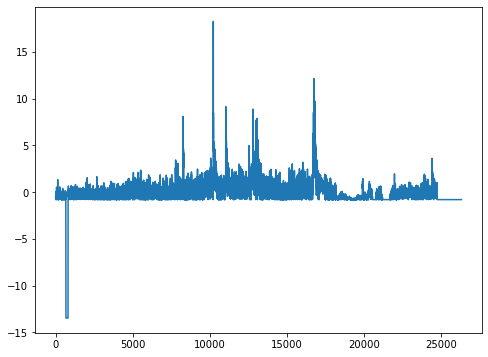

Test input shape:  (26111, 288, 1)


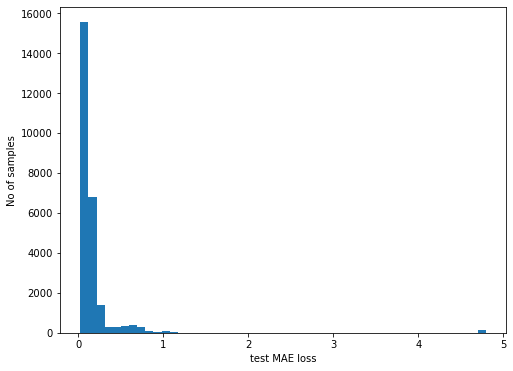

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)


In [306]:
df_test_value = (df_2['AV Flow (L/s)'] - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
x_test = x_test[..., None]
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [307]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

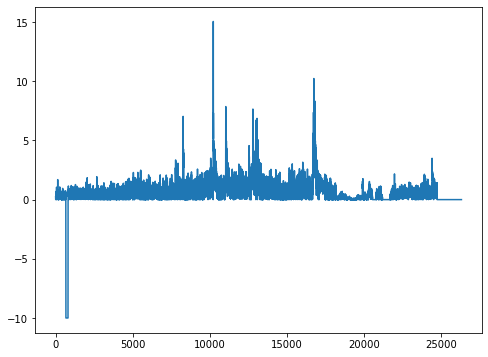

In [309]:
df_subset = df_2['AV Flow (L/s)'].iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_2['AV Flow (L/s)'].plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()